In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:42957")
client

<Client: 'tcp://127.0.0.1:42957' processes=7 threads=28, memory=177.10 GiB>

In [2]:
from cil.utilities import dataexample
from cil.processors import TransmissionAbsorptionConverter
from cil.utilities.display import show2D
from cil.plugins.astra.operators import ProjectionOperator
from cil.optimisation.functions import L2NormSquared
from cil.optimisation.algorithms import PDHG
from cil.plugins.ccpi_regularisation.functions import FGP_TV
from cil.plugins.astra.processors import FBP
from skimage.util import apply_parallel
import numpy as np

In [3]:
data = dataexample.SIMULATED_PARALLEL_BEAM_DATA.get()

data = TransmissionAbsorptionConverter()(data)
data.reorder('astra')

# data2D = tmp_data.get_slice(vertical='centre')

ag = data.geometry
ig = ag.get_ImageGeometry()


In [4]:
# code from https://github.com/emmanuelle/tomo-tv/blob/master/reconstruction/tv_denoising.py

def gradient(img):
    """ 
    Compute gradient of an image
    Parameters
    ===========
    img: ndarray
        N-dimensional image
    Returns
    =======
    gradient: ndarray
        Gradient of the image: the i-th component along the first
        axis is the gradient along the i-th axis of the original
        array img
"""
    shape = [img.ndim, ] + list(img.shape)
    gradient = np.zeros(shape, dtype=img.dtype)
    # 'Clever' code to have a view of the gradient with dimension i stop
    # at -1
    slice_all = [0, slice(None, -1),]
    for d in range(img.ndim):
        gradient[slice_all] = np.diff(img, axis=d)
        slice_all[0] = d + 1
        slice_all.insert(1, slice(None))
    return gradient



def div(grad):
    """ Compute divergence of image gradient """
    res = np.zeros(grad.shape[1:])
    for d in range(grad.shape[0]):
        this_grad = np.rollaxis(grad[d], d)
        this_res = np.rollaxis(res, d)
        this_res[:-1] += this_grad[:-1]
        this_res[1:-1] -= this_grad[:-2]
        this_res[-1] -= this_grad[-2]
    
    return res

def _projector_on_dual(grad):
    """
    modifies in place the gradient to project it
    on the L2 unit ball
    """
    norm = np.maximum(np.sqrt(np.sum(grad**2, 0)), 1.)
    for grad_comp in grad:
        grad_comp /= norm
             
    return grad


def tv_denoise_fista(im, weight=50, eps=5.e-5, n_iter_max=200,
                                check_gap_frequency=3):

    """
    Perform total-variation denoising on 2-d and 3-d images
    Find the argmin `res` of
        1/2 * ||im - res||^2 + weight * TV(res),
    where TV is the isotropic l1 norm of the gradient.
    Parameters
    ----------
    im: ndarray of floats (2-d or 3-d)
        input data to be denoised. `im` can be of any numeric type,
        but it is cast into an ndarray of floats for the computation
        of the denoised image.
    weight: float, optional
        denoising weight. The greater ``weight``, the more denoising (at
        the expense of fidelity to ``input``)
    eps: float, optional
        precision required. The distance to the exact solution is computed
        by the dual gap of the optimization problem and rescaled by the l2
        norm of the image (for contrast invariance).
    n_iter_max: int, optional
        maximal number of iterations used for the optimization.
    Returns
    -------
    out: ndarray
        denoised array
    Notes
    -----
    The principle of total variation denoising is explained in
    http://en.wikipedia.org/wiki/Total_variation_denoising
    The principle of total variation denoising is to minimize the
    total variation of the image, which can be roughly described as
    the integral of the norm of the image gradient. Total variation
    denoising tends to produce "cartoon-like" images, that is,
    piecewise-constant images.
    This function implements the FISTA (Fast Iterative Shrinkage
    Thresholding Algorithm) algorithm of Beck et Teboulle, adapted to
    total variation denoising in "Fast gradient-based algorithms for
    constrained total variation image denoising and deblurring problems"
    (2009).
    """
    # if not im.dtype.kind == 'f':
        # im = im.astype(np.float)
    shape = [im.ndim, ] + list(im.shape)
    grad_im = np.zeros(shape)
    grad_aux = np.zeros(shape)
    t = 1.
    i = 0
    while i < n_iter_max:
        error = weight * div(grad_aux) - im
        grad_tmp = gradient(error)
        grad_tmp *= 1./ (8 * weight)
        grad_aux += grad_tmp
        grad_tmp = _projector_on_dual(grad_aux)
        t_new = 1. / 2 * (1 + np.sqrt(1 + 4 * t**2))
        t_factor = (t - 1) / t_new
        grad_aux = (1 + t_factor) * grad_tmp - t_factor * grad_im
        grad_im = grad_tmp
        t = t_new
        # if (i % check_gap_frequency) == 0:
        gap = weight * div(grad_im)
        new = im - gap
        #     dgap = dual_gap(im, new, gap, weight)
        #     if dgap < eps:
        #         break
        i += 1
        
        
    return new

In [5]:
fbp = FBP(ig, ag, device="gpu")(data)

In [6]:
fbp.shape

(128, 128, 128)

In [7]:
weight = 0.1/ig.voxel_size_x
eps = 0
n_iter_max = 5
check_gap_frequency = 3
chunks =(64,64,64)

In [8]:
res1 = tv_denoise_fista(fbp.array, weight=weight, eps=eps, n_iter_max=n_iter_max, check_gap_frequency=check_gap_frequency)


/tmp/ipykernel_13374/2788705928.py:23: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  gradient[slice_all] = np.diff(img, axis=d)


In [9]:
%timeit -n 5 -r 5 tv_denoise_fista(fbp.array, weight=weight, eps=eps, n_iter_max=n_iter_max, check_gap_frequency=check_gap_frequency)


/tmp/ipykernel_13374/2788705928.py:23: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  gradient[slice_all] = np.diff(img, axis=d)


1.04 s ± 781 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [10]:
extra_keywords = dict(weight=weight, n_iter_max=n_iter_max, check_gap_frequency = check_gap_frequency)

res2 = apply_parallel(tv_denoise_fista, fbp.array, chunks=chunks, depth=16, dtype=fbp.dtype, extra_keywords=extra_keywords, compute=True)



In [ ]:
%timeit -n 5 -r 5 apply_parallel(tv_denoise_fista, fbp.array, chunks=chunks, depth=16, dtype=fbp.dtype, extra_keywords=extra_keywords, compute=True)


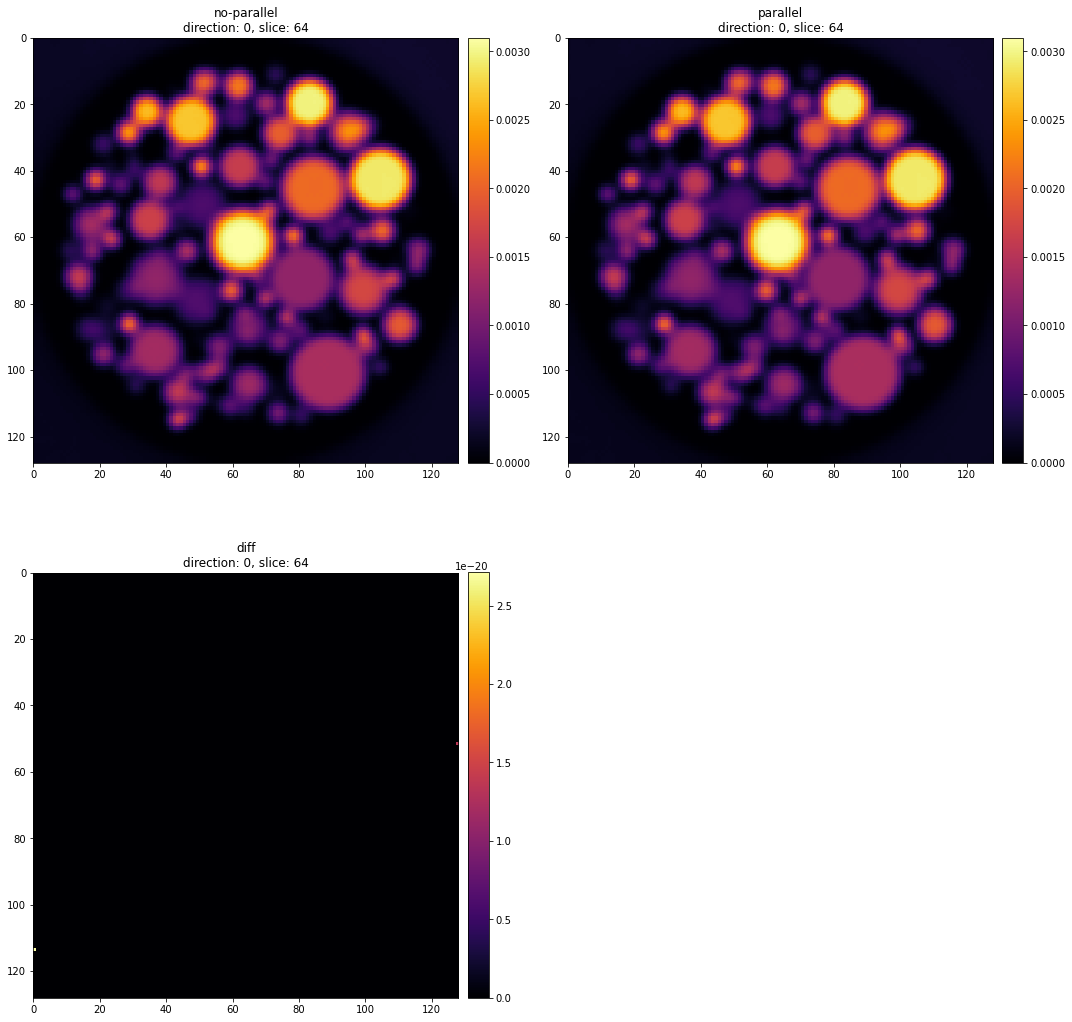

In [13]:
show2D([res1, res2, np.abs(res1-res2)], title=['no-parallel', 'parallel', 'diff'], origin = "upper", cmap="inferno")